In [1]:
import pandas as pd
import numpy as np
from datasets import load_dataset
from tqdm import tqdm
from collections import Counter

import enchant

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
random_state = 114514

## Load Data

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
cache_dir = "../data_cache"

train_dataset = load_dataset(
    "tweet_eval",
    name="emotion",
    split="train",
    cache_dir=cache_dir,
)
print(f"Training dataset with {len(train_dataset)} instances loaded")


val_dataset = load_dataset(
    "tweet_eval",
    name="emotion",
    split="validation",
    cache_dir=cache_dir,
)
print(f"Development/validation dataset with {len(val_dataset)} instances loaded")


test_dataset = load_dataset(
    "tweet_eval",
    name="emotion",
    split="test",
    cache_dir=cache_dir,
)
print(f"Test dataset with {len(test_dataset)} instances loaded")

# Access the input text and target labels like this...
train_texts = train_dataset['text']
train_labels = train_dataset['label']

val_texts = val_dataset['text']
val_labels = val_dataset['label']

test_texts = test_dataset['text']
test_labels = test_dataset['label']

Training dataset with 3257 instances loaded
Development/validation dataset with 374 instances loaded
Test dataset with 1421 instances loaded


In [5]:
Counter(train_labels)

Counter({0: 1400, 3: 855, 1: 708, 2: 294})

Text(0.5, 1.0, 'Emotion Distribution')

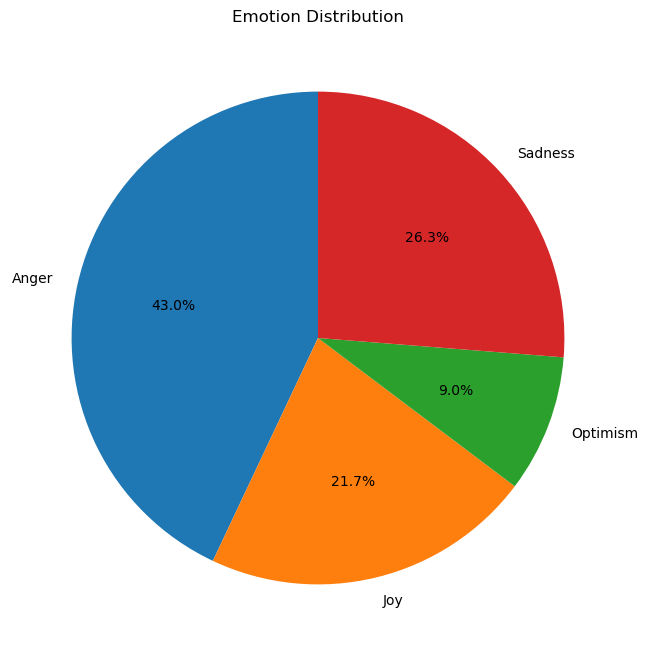

In [6]:
fig, ax = plt.subplots(figsize=(10,8))
labels = ["Anger", "Joy", "Optimism", "Sadness"]
Anger = Counter(train_labels)[0]
Joy = Counter(train_labels)[1]
Optimism = Counter(train_labels)[2]
Sadness = Counter(train_labels)[3]

ax.pie([Anger, Joy, Optimism, Sadness],labels=labels, autopct='%1.1f%%', 
          startangle=90,)
ax.set_title(f"Emotion Distribution")

# Data Preprocessing

In [7]:
import re
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [8]:
def is_English_word(word):
    return len(wordnet.synsets(word)) > 0

In [9]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer() 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yimin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
class DataPreprocessor:
    def __init__(self):
        self.__text = {
            'train': train_texts,
            'val': val_texts,
            'test': test_texts,
        }
    
    # Cleaning
    def remove_non_printable(self,text):
        def has_non_printable(text):
            non_printable_pattern = re.compile(r'[\x00-\x1F\x7F-\x9F]')
            match = re.search(non_printable_pattern, text)
            return bool(match)

        while True:
            non_printable_pattern = re.compile(r'[\x00-\x1F\x7F-\x9F]')
            text = re.sub(non_printable_pattern, '', text)
            if not has_non_printable(text):
                break   
        cleaned_text = text
        return cleaned_text
    
    def emoji_to_text(self,emoji_str):
        text = emoji.demojize(emoji_str)
        return text
    
    def remove_urls(self,text):
        url_pattern = re.compile(r'https?://\S+|www\.\S+')
        return url_pattern.sub('', text)
    
    def remove_mentions(self,text):
        mention_pattern = re.compile(r'@[\w_]+')
        return mention_pattern.sub('', text)
    
    def remove_hashtag_symbol(self, text):
        hashtag_pattern = re.compile(r'#(\w+)')
        return hashtag_pattern.sub(r'\1', text)
    
    # Tokenisation
    def text_tokenisation(self, text):
        tokens = nltk.word_tokenize(text)
        
        pattern = re.compile(r'[a-zA-Z]')
        filtered_tokens = []
        for token in tokens:
            if re.search(pattern, token):
                filtered_tokens.append(token)
        
        return filtered_tokens
    
    def remove_non_english_words(self, tokens):
        filtered_tokens = []
        for token in tokens:
            if is_English_word(token):
                filtered_tokens.append(token)
        return filtered_tokens
    
    def remove_stop_words(self, tokens):
        filtered_tokens = [word for word in tokens if word.lower() not in stop_words and len(word)>2] 
        return filtered_tokens
    
    # Lemmatisation
    def lemmatise_tokens(self, tokens):
        lemmatised_tokens = []
        for token in tokens:
            token = lemmatizer.lemmatize(token.lower(), pos='r')
            token = lemmatizer.lemmatize(token.lower(), pos='a')
            token = lemmatizer.lemmatize(token.lower(), pos='v')
            token = lemmatizer.lemmatize(token.lower(), pos='n')
            lemmatised_tokens.append(token)
        return lemmatised_tokens
    
    def __call__(self, dataset_type):
        tokenised_sents = []
        
        for sent in self.__text[dataset_type]:
            # Cleaning
            sent = self.remove_non_printable(sent)
            sent = self.emoji_to_text(sent)
            sent = self.remove_urls(sent)
            sent = self.remove_mentions(sent)
            sent = self.remove_hashtag_symbol(sent)
            # Tokenisation
            tokens = self.text_tokenisation(sent)
            tokens = self.remove_stop_words(tokens)
            tokens = self.remove_non_english_words(tokens)
            tokens = self.lemmatise_tokens(tokens)
            
            tokenised_sents.append(tokens)
        return tokenised_sents

In [11]:
data_preprocessor = DataPreprocessor()

In [12]:
X_train = data_preprocessor('train')
X_val = data_preprocessor('val')
X_test = data_preprocessor('test')

In [13]:
y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)

# Naive Bayes Classifier (Non-Neural Network Based Model)

## TF-IDF Vectoriser

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [15]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)
tfidf_vectorizer.fit(X_train)

C:\Users\yimin\anaconda3\envs\text_analytics\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TfidfVectorizer(lowercase=False,
                tokenizer=<function <lambda> at 0x000001CDD818E5C0>)

In [16]:
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

## Count Vectoriser

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

In [18]:
count_vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False)
count_vectorizer.fit(X_train)

CountVectorizer(lowercase=False,
                tokenizer=<function <lambda> at 0x000001CDD826C0E0>)

In [19]:
X_train_count = count_vectorizer.transform(X_train)
X_val_count= count_vectorizer.transform(X_val)
X_test_count = count_vectorizer.transform(X_test)

## Model Trainning

In [20]:
from sklearn.naive_bayes import MultinomialNB

In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [22]:
from sklearn.model_selection import StratifiedKFold

In [23]:
def confusion_matrix_plot(y_true, y_pred, model):
    conf_matrix = confusion_matrix(y_true, y_pred)

    fig,ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title('Confusion Matrix')
    plt.show()

In [24]:
def result_evaluation(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    metrics = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1-score": f1
    }
    return metrics

In [25]:
def k_fold_validation(texts, labels, model=MultinomialNB()):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    scores = [] 
    
    for train_idx, val_idx in cv.split(texts, labels):
        train_sets, val_sets = texts[train_idx], texts[val_idx]
        train_labels, val_labels = labels[train_idx], labels[val_idx]
        model.fit(train_sets, train_labels)
        pred_labels = model.predict(val_sets)
        scores.append(result_evaluation(val_labels, pred_labels))
        
    metrics = {
        "accuracy": 0,
        "precision": 0,
        "recall": 0,
        "f1-score": 0
    }
    
    for s in scores:
        for k in metrics.keys():
            metrics[k] += s[k]
    
    for k in metrics.keys():
        metrics[k] /= 5
    
    return metrics

In [26]:
nb_metrics_tfidf = k_fold_validation(X_train_tfidf, y_train)
nb_metrics_count = k_fold_validation(X_train_count, y_train)

In [27]:
nb_metrics_tfidf

{'accuracy': 0.6349349278599229,
 'precision': 0.7898677793673867,
 'recall': 0.4732882461628821,
 'f1-score': 0.47862970174023217}

In [28]:
nb_metrics_count

{'accuracy': 0.6868220670417384,
 'precision': 0.6486462367733339,
 'recall': 0.5898469161271365,
 'f1-score': 0.6044452270077441}

#  (Neural Network Based Model)

In [45]:
from gensim.models import Word2Vec

In [46]:
Word2Vec_model = Word2Vec(X_train, vector_size=64, window=5, min_count=5, workers=5, sg=1)
Word2Vec_model.save("../model/Word2Vec_model.bin")

In [47]:
def pad_sentences(sentences, max_length, vector_size, padding_value=0):
    padded_sentences = []
    for sentence in sentences:
        if len(sentence) < max_length:
            padding_length = max_length - len(sentence)
            padded_sentence = sentence + [[padding_value]*vector_size] * padding_length
            padded_sentences.append(padded_sentence)
        else:
            padded_sentence = sentence[:max_length]
            padded_sentences.append(padded_sentence)
    return padded_sentences

def words_to_vector(sentences, padding_value=0):
    model = Word2Vec.load("../model/Word2Vec_model.bin")
    max_length = max(len(sentence) for sentence in sentences)
    word_matrix = []
    for sentence in sentences:
        word_vectors = []
        for word in sentence:
            if word in model.wv:
                word_vectors.append(model.wv[word])
            else:
                word_vectors.append([0] * model.vector_size)
        word_matrix.append(word_vectors)
    # Padding the sentences to make the length consistent
    padded_word_matrix = pad_sentences(word_matrix, max_length, model.vector_size, padding_value)
    return np.array(padded_word_matrix)


In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [70]:
X_train_wv = torch.tensor(words_to_vector(X_train), dtype=torch.float32)
X_val_wv = torch.tensor(words_to_vector(X_val), dtype=torch.float32)
X_test_wv = torch.tensor(words_to_vector(X_test), dtype=torch.float32)

In [73]:
y_train_one_hot = torch.tensor(np.eye(4)[y_train], dtype=torch.float32)
y_val_one_hot = torch.tensor(np.eye(4)[y_val], dtype=torch.float32)
y_test_one_hot = torch.tensor(np.eye(4)[y_test], dtype=torch.float32)

In [74]:
train_dataset = TensorDataset(X_train_wv, y_train_one_hot)
val_dataset = TensorDataset(X_val_wv, y_val_one_hot)
test_dataset = TensorDataset(X_test_wv, y_test_one_hot)

batch_size = 64  # Adjust batch size as needed

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [75]:
class SentimentClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, num_heads=2, dropout=0.1):
        super(SentimentClassifier, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        
        # Multihead Attention
        self.attention = nn.MultiheadAttention(input_dim, num_heads=num_heads, dropout=dropout)
        
        # GRU layer
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # Apply Multihead Attention
        x, _ = self.attention(x, x, x)
        
        # Apply GRU layer
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        output, _ = self.gru(x, h_0)
        
        # Apply dropout
        output = self.dropout(output)
        
        # Get the last output from GRU
        output = output[:, -1, :]
        
        # Fully connected layer
        output = self.fc(output)
        
        return output

In [76]:
# Define model parameters
input_dim = 64  # Input features
hidden_dim = 128  # Hidden units
output_dim = 4  # Number of classes
num_layers = 1  # Number of GRU layers
num_heads = 2  # Number of attention heads
dropout = 0.1  # Dropout rate

# Create an instance of the model
model = SentimentClassifier(input_dim, hidden_dim, output_dim, num_layers, num_heads, dropout)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Print the model architecture
print(model)

SentimentClassifier(
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (gru): GRU(64, 128, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=128, out_features=4, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


C:\Users\yimin\anaconda3\envs\text_analytics\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [78]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define number of epochs
num_epochs = 1

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    # Print average loss for this epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Evaluation on the validation set
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
#             correct += (predicted == labels).sum().item()
    
#     # Print validation loss and accuracy
#     val_loss /= len(val_loader.dataset)
#     accuracy = correct / total
#     print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")

Epoch [1/1], Loss: 1.2672


In [66]:
model

SentimentClassifier(
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (gru): GRU(64, 128, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=128, out_features=4, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)